# Exploratory Data Analysis



## Setup



In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("diabetic_data.csv")

## Exploratory Visual Analysis for Research Questions

Variables w/ datatypes: 

 encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              

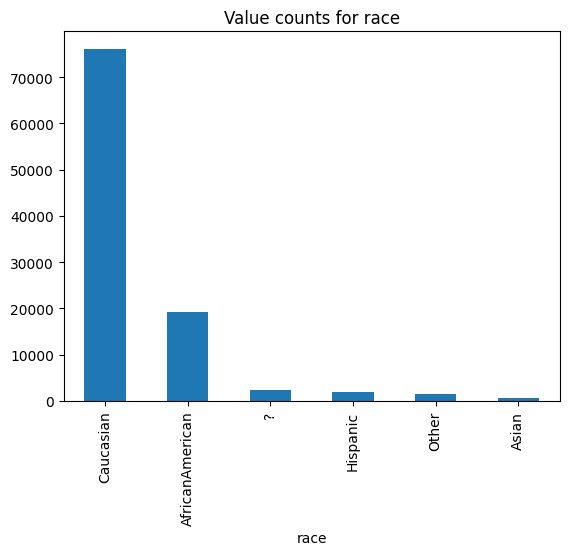

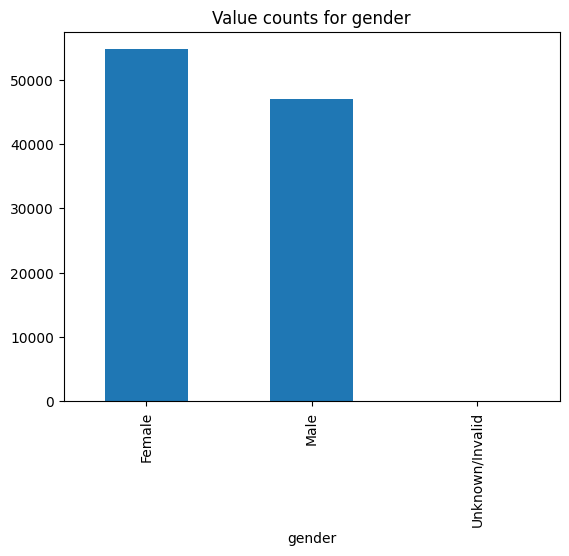

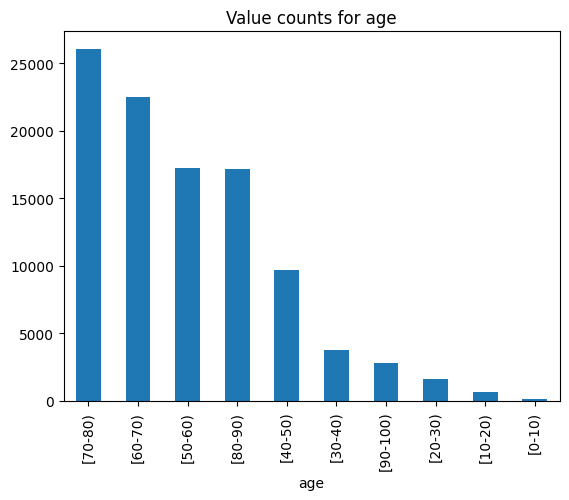

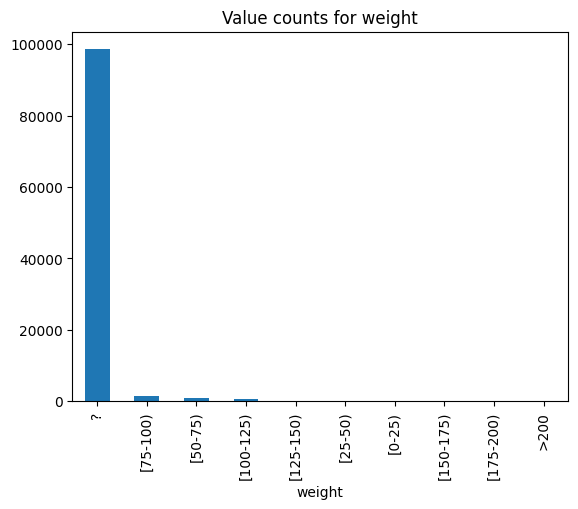

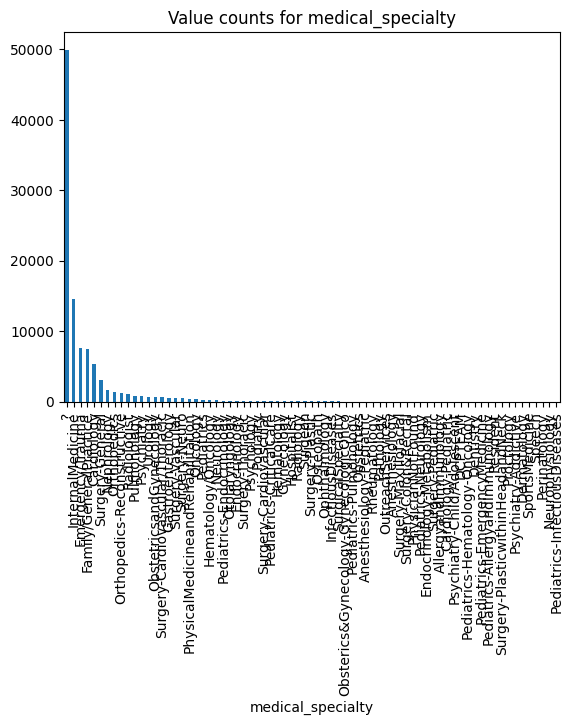

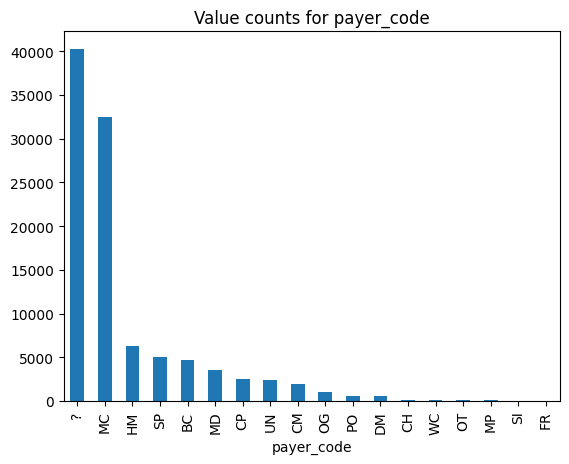

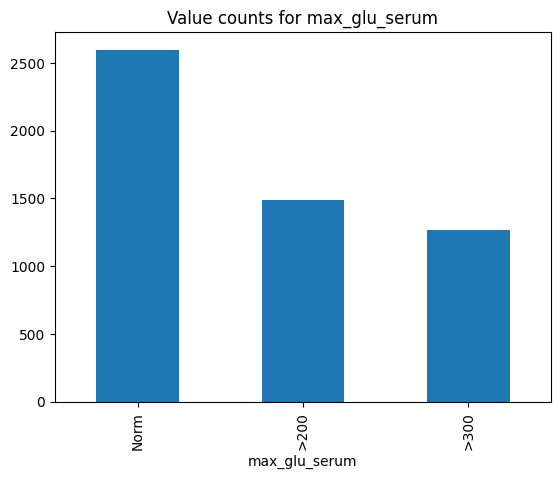

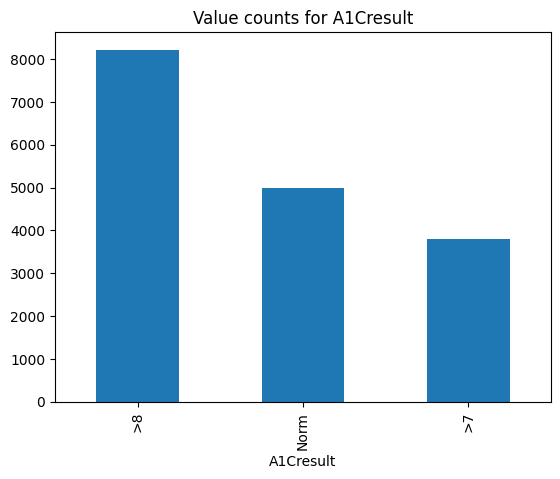

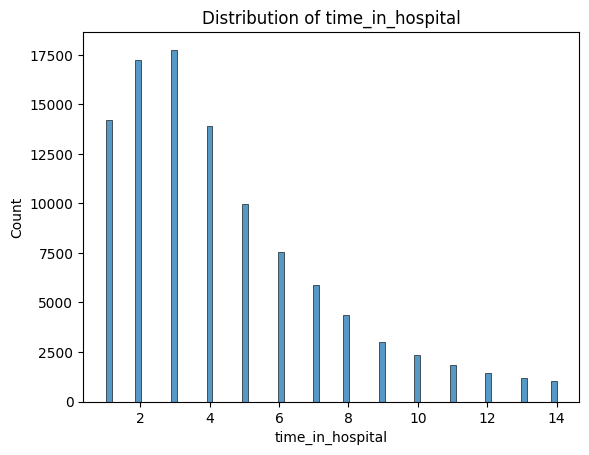

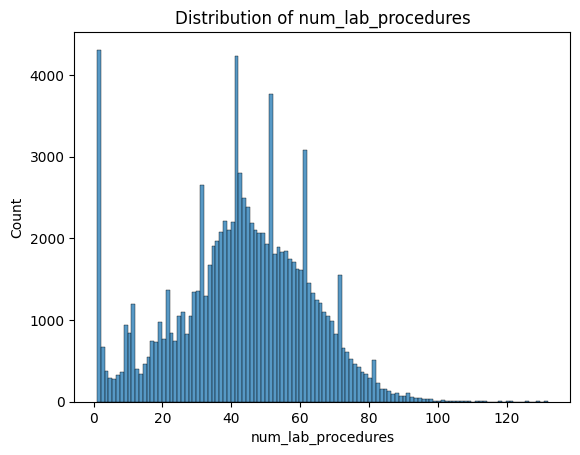

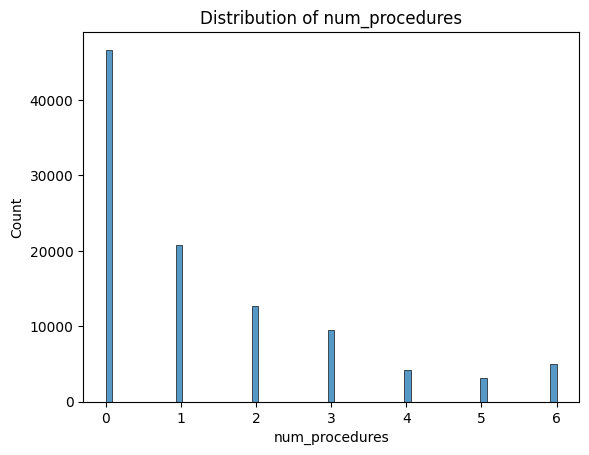

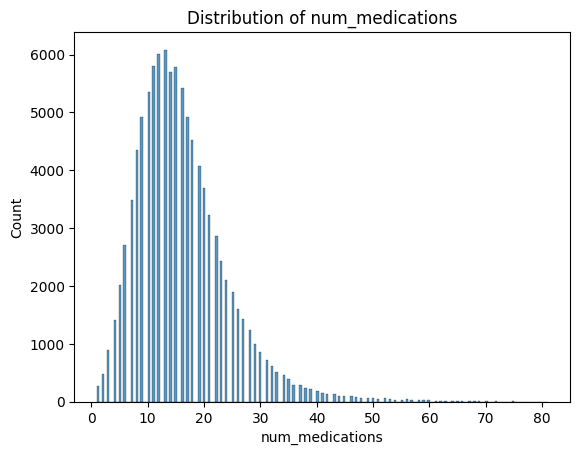

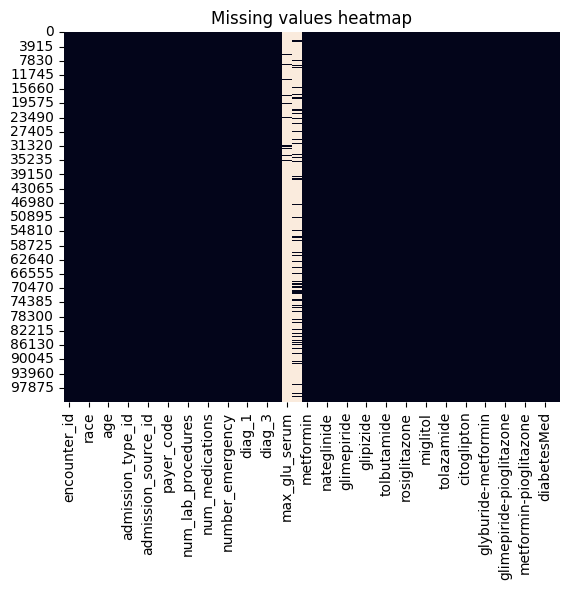

In [29]:
# initial exploration of the dataset
print("Variables w/ datatypes: \n\n", df.dtypes)

print("\n\n\n\nSummary statistics:\n\n", df.describe())

print("\n\n\n\nAre there duplicate entries for unique identifiers: \n")

print("\nEncounter ID:", df.duplicated(subset='encounter_id').unique())

categorical_cols = ['race', 'gender', 'age', 'weight', 'medical_specialty', 'payer_code', 'max_glu_serum', 'A1Cresult']
for col in categorical_cols:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Value counts for {col}')
    plt.show()

numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']
for col in numerical_cols:
    sns.histplot(df[col].dropna())
    plt.title(f'Distribution of {col}')
    plt.show()

sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing values heatmap')
plt.show()






In [30]:
import pandas as pd
import plotly.graph_objects as go

# --- columns (rename to yours) ---
A = "admission_type_id"
B = "discharge_disposition_id"
C = "readmitted"              # your 3rd target
pct = 0.01                    # 1% threshold (per column)
ELSE = "Other"

def bucket_small(df, col, pct=0.01, else_label="Other"):
    s = df[col].astype(str).fillna("Unknown")
    vc = s.value_counts()
    total = len(s)
    small_vals = vc[vc / total < pct].index
    return s.where(~s.isin(small_vals), else_label)

# 1) Collapse rare categories per column
df2 = df.copy()
for col in [A, B, C]:
    df2[col] = bucket_small(df2, col, pct=pct, else_label=ELSE)

# 2) Aggregate flows for A→B and B→C
ab = (df2[[A, B]].groupby([A, B]).size()
      .reset_index(name="value"))
bc = (df2[[B, C]].groupby([B, C]).size()
      .reset_index(name="value"))

# 3) Build node lists (keep layers distinct to avoid loops)
A_vals = sorted(ab[A].unique().tolist())
B_vals = sorted(pd.Index(ab[B]).union(bc[B]).unique().tolist())
C_vals = sorted(bc[C].unique().tolist())

labels_pretty = A_vals + B_vals + C_vals

# index offsets
a_off = 0
b_off = len(A_vals)
c_off = b_off + len(B_vals)
a_idx = {v: a_off + i for i, v in enumerate(A_vals)}
b_idx = {v: b_off + i for i, v in enumerate(B_vals)}
c_idx = {v: c_off + i for i, v in enumerate(C_vals)}

# links
src =  ab[A].map(a_idx).tolist() +  bc[B].map(b_idx).tolist()
tgt =  ab[B].map(b_idx).tolist() +  bc[C].map(c_idx).tolist()
val =  ab["value"].tolist()      +  bc["value"].tolist()

# pin three vertical columns
xpos = [0]*len(A_vals) + [0.5]*len(B_vals) + [1]*len(C_vals)

fig = go.Figure(go.Sankey(
    node=dict(label=labels_pretty, pad=15, thickness=14, x=xpos, y=None),
    link=dict(source=src, target=tgt, value=val)
))
fig.update_layout(title="Admissions → Discharge → Outcome (rare <1% grouped as Other)")
fig.show()
